L'objectif ce cet notebook, c'est de requêter et afficher une addresse saisie par l'utilisateur

In [1]:
# Install the required packages
#%pip install pandas sqlalchemy folium requests beautifulsoup4 numpy pyodbc jupysql

import pandas as pd
import subprocess
import os
from sqlalchemy.engine import URL
from sqlalchemy.engine import create_engine
from sqlalchemy import text
import folium
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import StringIO
import glob
import numpy as np
import re
from shapely import wkt
import geopandas as gpd


connection_url = URL.create(
    "mssql+pyodbc",
    username="sa",
    password="Stu@wr3r",
    host="109.222.166.90",
    port=8282,
    database="insee",
    query={
        "driver": "ODBC Driver 18 for SQL Server",
        "TrustServerCertificate": "yes",
    },
)

engine = create_engine(connection_url)
conn = engine.connect()
trans = conn.begin()
df_dept = conn.execute(text('SELECT 42')).fetchall()
trans.commit()



In [2]:
filename = f'adresses.txt'
output_file = 'rich_adress.txt'
import subprocess
import os

# Input and output file paths
filename = 'adresses.txt'
output_file = 'rich_adress.txt'

# Ensure the input file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"The input file '{filename}' does not exist.")

# Define the curl command
curl_command = f"""
curl -X POST \
-F data=@{filename} \
-F columns=adresse \
-F columns=commune \
-F columns=code_postal \
-F result_columns=latitude \
-F result_columns=longitude \
-F result_columns=result_type \
-F result_columns=result_score \
-F result_columns=result_name \
-F result_columns=result_postcode \
-F result_columns=result_citycode \
-F result_columns=result_city \
-F result_columns=result_status \
"https://api-adresse.data.gouv.fr/search/csv/" \
-o {output_file}
"""

# Execute the curl command
process = subprocess.run(curl_command, shell=True)

# Check the process result
if process.returncode != 0:
    raise RuntimeError(f"Curl command failed with return code {process.returncode}.")
else:
    print(f"Output written to {output_file}")

  
# Exécuter la commande curl pour chaque partie
print("Executing command:", curl_command)
subprocess.run(curl_command, shell=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2007    0   306  100  1701    800   4448 --:--:-- --:--:-- --:--:--  5240
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Output written to rich_adress.txt
Executing command: 
curl -X POST -F data=@adresses.txt -F columns=adresse -F columns=commune -F columns=code_postal -F result_columns=latitude -F result_columns=longitude -F result_columns=result_type -F result_columns=result_score -F result_columns=result_name -F result_columns=result_postcode -F result_columns=result_citycode -F result_columns=result_city -F result_columns=result_status "https://api-adresse.data.gouv.fr/search/csv/" -o rich_adress.txt



100  2007    0   306  100  1701    868   4828 --:--:-- --:--:-- --:--:--  5701


CompletedProcess(args='\ncurl -X POST -F data=@adresses.txt -F columns=adresse -F columns=commune -F columns=code_postal -F result_columns=latitude -F result_columns=longitude -F result_columns=result_type -F result_columns=result_score -F result_columns=result_name -F result_columns=result_postcode -F result_columns=result_citycode -F result_columns=result_city -F result_columns=result_status "https://api-adresse.data.gouv.fr/search/csv/" -o rich_adress.txt\n', returncode=0)

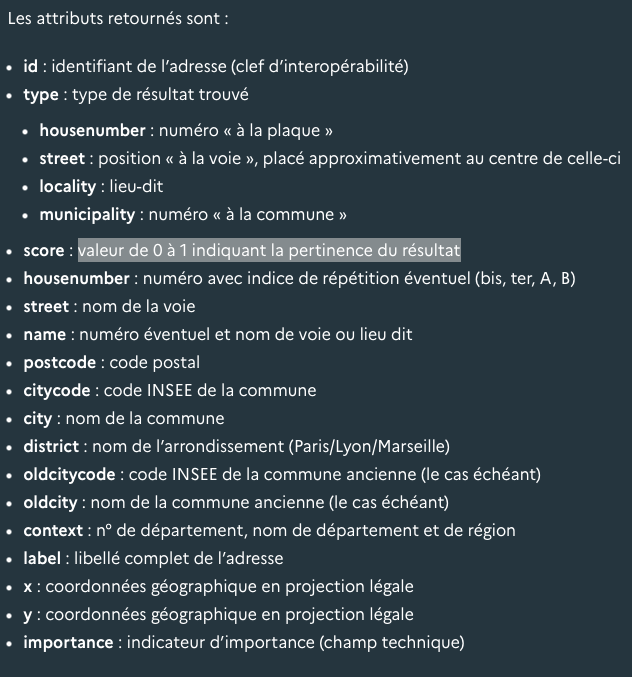

https://adresse.data.gouv.fr/api-doc/adresse

In [3]:
df_adress = pd.read_csv('rich_adress.txt')

df_adress['result_postcode'] = df_adress['result_postcode'].astype(str).apply(lambda x: '0' + x if re.match(r'^\d{4}\.0$', str(x)) else x)
df_adress['result_postcode'] = df_adress['result_postcode'].astype(str).str.replace('.0', '').str.zfill(5)

df_adress['result_citycode'] = df_adress['result_citycode'].astype(str).str.replace('.0', '').str.zfill(5)

df_adress



,Unnamed: 0,adresse,commune,code_postal,latitude,longitude,result_type,result_score,result_name,result_postcode,result_citycode,result_city,result_status
0,0,6 rue marcel baconnier,Saint Laurent de mure,69720,45.684731,5.042055,housenumber,0.923517,6 Rue Marcel Baconnier,69720,69288,Saint-Laurent-de-Mure,ok


In [4]:
query = f"""
SELECT CIG.code_iris
FROM Insee.dbo.codes_iris_geometrie CIG
WHERE CAST({df_adress.result_citycode[0]} AS VARCHAR(5)) = SUBSTRING(CIG.code_iris, 1, 5) COLLATE French_CI_AS 
AND CIG.geography.STContains(
        geography::STPointFromText(
            'POINT(' + CAST({df_adress.longitude[0]} AS VARCHAR(20)) + ' ' + CAST({df_adress.latitude[0]} AS VARCHAR(20)) + ')', 4326
        )
    ) = 1
AND CIG.ANNEE = 2023;
"""
print(query)
conn = engine.connect()
trans = conn.begin() 
df_adress['code_iris'] = conn.execute(text(query)).fetchone()
trans.commit()  




SELECT CIG.code_iris
FROM Insee.dbo.codes_iris_geometrie CIG
WHERE CAST(69288 AS VARCHAR(5)) = SUBSTRING(CIG.code_iris, 1, 5) COLLATE French_CI_AS 
AND CIG.geography.STContains(
        geography::STPointFromText(
            'POINT(' + CAST(5.042055 AS VARCHAR(20)) + ' ' + CAST(45.684731 AS VARCHAR(20)) + ')', 4326
        )
    ) = 1
AND CIG.ANNEE = 2023;



In [5]:
query = f"""
SELECT BG.code_id_bv
FROM 
    Elections.dbo.bureaux_geometrie BG  
WHERE
    CAST({df_adress.result_citycode[0]} AS VARCHAR(5)) = BG.codgeo COLLATE French_CI_AS 
    AND BG.geography.STDistance(
        geography::STPointFromText(
            'POINT(' + CAST({df_adress.longitude[0]} AS VARCHAR(20)) + ' ' + CAST({df_adress.latitude[0]} AS VARCHAR(20)) + ')', 4326)
    ) > 0;
    """
conn = engine.connect()
trans = conn.begin()
df_adress['code_id_bv'] = conn.execute(text(query)).fetchone()
trans.commit() 

df_adress

SystemError: <class 'pyodbc.Error'> returned a result with an exception set

In [ ]:

# Define the parameterized query
query = f"""
SELECT 
    CIG.geography.STAsText() AS geometry_iris,
    CCG.geography.STAsText() AS geometry_commune,
    BG.geography.STAsText() AS geometry_bv
    
FROM
    Insee.dbo.codes_iris_geometrie CIG,
    Insee.dbo.codes_communes_geometrie CCG,
    Elections.dbo.bureaux_geometrie BG
    
WHERE '{df_adress.code_iris[0]}' = CIG.code_iris
AND CIG.ANNEE = 2023
OR CAST({df_adress.result_citycode[0]} AS VARCHAR(9)) = CCG.codgeo
OR '{df_adress.code_id_bv[0]}' = BG.code_id_bv
    ;
"""
df_geos = pd.read_sql_query(query, engine)
df_adress['geometry_iris'] = df_geos.geometry_iris[0]
df_adress['geometry_commune'] = df_geos.geometry_commune[0]
df_adress['geometry_bv'] = df_geos.geometry_bv[0]

df_adress['geometry_iris'] = df_adress['geometry_iris'].apply(wkt.loads)
df_adress['geometry_commune'] = df_adress['geometry_commune'].apply(wkt.loads)
df_adress['geometry_bv'] = df_adress['geometry_bv'].apply(wkt.loads)

# Création des GeoDataFrames pour chaque contour
gdf_iris = gpd.GeoDataFrame(df_adress, geometry='geometry_iris', crs="EPSG:4326")
gdf_commune = gpd.GeoDataFrame(df_adress, geometry='geometry_commune', crs="EPSG:4326")
gdf_bv = gpd.GeoDataFrame(df_adress, geometry='geometry_bv', crs="EPSG:4326")

gdf_iris = gdf_iris.drop(columns=['geometry_commune', 'geometry_bv'])
gdf_commune = gdf_commune.drop(columns=['geometry_iris', 'geometry_bv'])
gdf_bv = gdf_bv.drop(columns=['geometry_iris', 'geometry_commune'])

KeyError: 0

In [ ]:
query = """
SELECT 
    nom,
    dep,
    geography.STAsText() AS geography_dpt
FROM Insee.dbo.codes_departements_geometrie
"""
df_dpt = pd.read_sql_query(query, engine)

# Conversion des colonnes WKT en géométries
df_dpt['geography_dpt'] = df_dpt['geography_dpt'].apply(wkt.loads)

# Création des GeoDataFrames pour chaque contour
gdf_dpt = gpd.GeoDataFrame(df_dpt, geometry='geography_dpt', crs="EPSG:4326")

In [ ]:
gdf_bv['geometry_bv'] = gdf_bv['geometry_bv'].simplify(0.005)
gdf_iris['geometry_iris'] = gdf_iris['geometry_iris'].simplify(0.005)
gdf_commune['geometry_commune'] = gdf_commune['geometry_commune'].simplify(0.005)
gdf_dpt['geography_dpt'] = gdf_dpt['geography_dpt'].simplify(0.005)

In [ ]:
# Créer une carte centrée sur les coordonnées moyennes des adresses
carte = folium.Map(width=700, height=700, location=[df_adress['latitude'].mean(), df_adress['longitude'].mean()], zoom_start=9)

# Ajouter des marqueurs pour chaque adresse
for _, row in df_adress.iterrows():
    location = [row['latitude'], row['longitude']]
    texte = f"""
        <div style="font-size: 12px;">
            <b>Adresse:</b> {row['adresse']}<br>
            <b>Commune:</b> {row['commune']}
        </div>
        """
    marqueur = folium.Marker(location=location, popup=folium.Popup(texte, max_width=250), icon=folium.Icon(color="darkred", icon="info-sign"))
    marqueur.add_to(carte)

# Ajouter la couche des contours Commune avec un contour vert plus foncé sans fond
folium.GeoJson(
    gdf_commune,
    name="Contours Commune",
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'darkgreen',
        'weight': 1.5,
        'fillOpacity': 0.5 
    }
).add_to(carte)

# Ajouter la couche des contours Iris avec un contour bleu clair sans fond
folium.GeoJson(
    gdf_iris,
    name="Contours Iris",
    style_function=lambda feature: {
        'fillColor': 'lightblue',
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0.5
    }
).add_to(carte)

# Ajouter la couche des contours Bureau de Vote avec un contour orange sans fond
folium.GeoJson(
    gdf_bv,
    name="Contours Bureau de Vote",
    style_function=lambda feature: {
        'fillColor': 'orange',
        'color': 'orange',
        'weight': 1.5,
        'fillOpacity': 0.5
    }
).add_to(carte)

# Ajouter la couche des contours Département avec un contour rouge sans fond
folium.GeoJson(
    gdf_dpt,
    name="Contours Département",
    style_function=lambda feature: {
        'fillColor': 'red',
        'color': 'darkred',
        'weight': 2,
        'fillOpacity': 0  # Pas de fond
    }
).add_to(carte)

# Ajouter le contrôle de couche pour afficher/masquer les contours
folium.LayerControl().add_to(carte)

# Afficher la carte
carte